In [1]:
import xarray as xr
import os
import pandas as pd
import cmweather
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from dask_jobqueue import SLURMCluster
from distributed import Client, progress
from scipy.interpolate import interp1d

In [2]:
cluster = SLURMCluster(cores=36, processes=6, memory='128GB', walltime='6:00:00')
cluster.scale(12)

In [3]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://140.221.70.6:8787/status,
Dashboard: http://140.221.70.6:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://140.221.70.6:43821,Workers: 0
Dashboard: http://140.221.70.6:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Data integrity check

In [9]:
listy = glob('/lcrc/group/earthscience/rjackson/kazrcloudsat/nsaarsclkazrcloudsatC1.c1.*.nc')
for fi in listy:
    try:
        ds = xr.open_dataset(fi)
        ds.close()
    except RuntimeError:
        print("Removing %s" % fi)
        os.remove(fi)
        

## Data resampling

In [20]:
i = 0
dest_dir = '/lcrc/group/earthscience/rjackson/kazrcloudsat/hourly_ave/'
listy = glob('/lcrc/group/earthscience/rjackson/kazrcloudsat/nsaarsclkazrcloudsatC1.c1.*.nc')
futures = client.map(resample_to_hour, listy)
progress(futures)


VBox()

In [40]:
listy = glob('/lcrc/group/earthscience/rjackson/kazrcloudsat/nsaarsclkazrcloudsatC1.c1.*.nc')
ds = xr.open_dataset('../data/nsakazrgeC1.b1.20111112.000000.cdf')

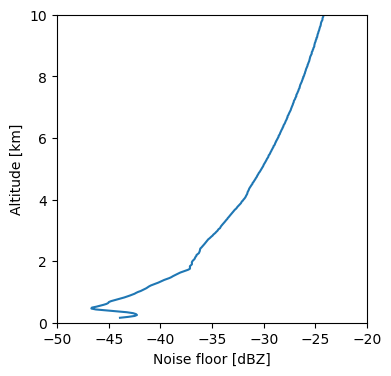

In [52]:
noise_floor = ds['reflectivity_copol'].where(ds['signal_to_noise_ratio_copol'] < 0).mean(dim='time').values
plt.figure(figsize=(4, 4))
plt.plot(noise_floor, ds["range"].values / 1e3)
plt.ylim([0, 10])
plt.ylabel('Altitude [km]')
plt.xlabel('Noise floor [dBZ]')
plt.xlim([-50, -20])
plt.savefig('noise_floor.png', bbox_inches='tight')

In [15]:
def resample_to_hour(file_name):
    try:
        ds = xr.open_dataset(file_name)
        base, path = os.path.split(file_name)
        ds['reflectivity_best_estimate'] = ds['reflectivity_best_estimate'].where(ds['reflectivity_clutter_flag'] == 1, drop=False)
        ds['mean_doppler_velocity'] = ds['mean_doppler_velocity'].where(ds['reflectivity_clutter_flag'] == 1, drop=False)
        ds['spectral_width'] = ds['spectral_width'].where(ds['spectral_width'] == 1, drop=False)
        ds = ds.resample(time='1h').mean()
        out_path = os.path.join(dest_dir, path)
        ds.to_netcdf(out_path)
        ds.close()
    except RuntimeError:
        return

In [43]:
nsa_data_path = '/lcrc/group/earthscience/NSA/Johannes-ck-new.dat'
nsa_cluster = pd.read_csv(nsa_data_path, index_col=["time"], parse_dates=True).to_xarray()

In [36]:
plt.plot(e3sm_avgs.time.dt.values)

AttributeError: 'DatetimeAccessor' object has no attribute 'values'

In [2]:
e3sm_columns = xr.open_dataset('subcols.nc')
e3sm_avgs = xr.open_dataset('E3SM_NSA_col_hourly_dump.nc')

In [46]:
dest_dir = '/lcrc/group/earthscience/rjackson/kazrcloudsat/hourly_ave/*.nc'
file_list = glob(dest_dir)
ds = xr.open_dataset(file_list[0])
heights = ds.height.values
ds.close()
refls = []
clusters = []
vels = []
seasons = []
for fi in file_list:
    ds = xr.open_dataset(fi)

    heights = ds.height.values
    refls.append(ds.reflectivity_best_estimate.values)
    vels.append(ds.mean_doppler_velocity.values)
    try:
        clusters.append(nsa_cluster["class"].sel(time=ds.time.values[0]).values * np.ones(ds.time.values.shape))
    except KeyError:
        clusters.append(np.nan*np.ones(ds.time.values.shape))
    try:
        seasons.append(ds.time.dt.season.values)
    except:
        seasons.append(np.nan*np.ones(ds.time.values.shape))
 
refls = np.concatenate(refls, axis=0)
vels = np.concatenate(vels, axis=0)
clusters = np.concatenate(clusters, axis=0)
seasons = np.concatenate(seasons, axis=0)

In [45]:
clusters = np.concatenate([x.squeeze() for x in clusters], axis=0)

AttributeError: 'list' object has no attribute 'squeeze'

In [47]:
clusters

array([4., 4., 4., ..., 3., 3., 3.])

In [27]:
refl_bins = np.linspace(-50, 20, 40)
hists_ref = np.zeros((4, len(heights), len(refl_bins) - 1))
vel_bins = np.linspace(-2, 2, 40)
hists_vel = np.zeros((4, len(heights), len(vel_bins) - 1))
medians_ref = np.zeros((4, len(heights)))
medians_vel = np.zeros((4, len(heights)))  

for c in range(4):
    which_inds = np.argwhere(clusters == c+1)
    for h in range(len(heights)):
        hist, bins = np.histogram(refls[which_inds, h], bins=refl_bins)
        hists_ref[c, h] = hist / np.sum(hist)
        medians_ref[c, h] = np.nanpercentile(refls[which_inds, h], 50)
        hist, bins = np.histogram(vels[which_inds, h], bins=vel_bins)
        hists_vel[c, h] = hist / np.sum(hist)
        medians_vel[c, h] = np.nanpercentile(vels[which_inds, h], 50)
hists_ref = np.where(hists_ref > 0, hists_ref, np.nan)
hists_vel = np.where(hists_vel > 0, hists_vel, np.nan)

/tmp/ipykernel_2038/4269008533.py:12: RuntimeWarning: divide by zero encountered in divide
  hists_ref[c, h] = hist / np.sum(hist)
/tmp/ipykernel_2038/4269008533.py:12: RuntimeWarning: invalid value encountered in divide
  hists_ref[c, h] = hist / np.sum(hist)
/gpfs/fs1/home/rjackson/mambaforge/envs/pyart_bebop/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/tmp/ipykernel_2038/4269008533.py:15: RuntimeWarning: divide by zero encountered in divide
  hists_vel[c, h] = hist / np.sum(hist)
/tmp/ipykernel_2038/4269008533.py:15: RuntimeWarning: invalid value encountered in divide
  hists_vel[c, h] = hist / np.sum(hist)


In [4]:
Rd = 287.057
g0 = 9.80665
e3sm_avgs["P"] = e3sm_avgs["hyam"] * e3sm_avgs["P0"] + e3sm_avgs["hybm"] * e3sm_avgs["PS"]
e3sm_avgs["heights"] = Rd * e3sm_avgs["T"] * (-np.log(e3sm_avgs["P"]) + np.log(e3sm_avgs["PS"])) / g0 * 1e-3
rho = e3sm_avgs["P"] / (Rd * e3sm_avgs["T"])
content_conversion_factor = rho * 1e3
e3sm_avgs["CLOUD_FILTER"] = e3sm_avgs["CLOUD"].where(e3sm_avgs["CLOUD"] > 0.01)
LWC_array = e3sm_avgs["CLDLIQ"].values / e3sm_avgs["CLOUD_FILTER"].values * content_conversion_factor
IWC_array = e3sm_avgs["CLDICE"].values / e3sm_avgs["CLOUD_FILTER"].values * content_conversion_factor
LWC_array += e3sm_avgs["RAINQM"].values * content_conversion_factor
IWC_array += e3sm_avgs["SNOWQM"].values * content_conversion_factor
LWC_array = np.where(np.isfinite(LWC_array), LWC_array, 0)
IWC_array = np.where(np.isfinite(IWC_array), IWC_array, 0)
Ze = e3sm_columns["sub_col_Ze_tot"].mean(dim='subcolumn', skipna=True)

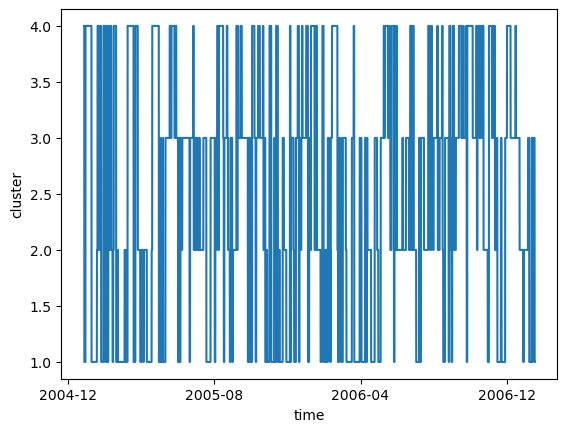

In [19]:
tolerance = np.timedelta64(1, 'D') / np.timedelta64(1, 'ns')
nsa_cluster = nsa_cluster.sortby('time').convert_calendar('noleap').reindex(time=e3sm_avgs.time, method='nearest')
e3sm_avgs["cluster"] = nsa_cluster["class"]
e3sm_avgs["cluster"].plot()

In [5]:
clear_pct = 1 - e3sm_avgs["CLOUD"].values
height = np.sort(e3sm_avgs["heights"].values)
heights_prof = np.arange(0, 10000, 50.)
LWC_array_interp = np.zeros((LWC_array.shape[0], len(heights_prof)))
IWC_array_interp = np.zeros((LWC_array.shape[0], len(heights_prof)))
clear_array_interp = np.zeros((LWC_array.shape[0], len(heights_prof)))
Ze_array_interp = np.zeros((LWC_array.shape[0], len(heights_prof)))
for i in range(LWC_array.shape[0]):
    if i % 100 == 0:
        print('%d/%d' % (i, LWC_array.shape[0]))
    LWC = interp1d(height[i, :], LWC_array[i, :], fill_value="extrapolate")
    IWC = interp1d(height[i, :], IWC_array[i, :], fill_value="extrapolate")
    clear = interp1d(height[i, :], clear_pct[i, :], fill_value="extrapolate")
    Zei = interp1d(height[i, :], Ze[i, :], fill_value="extrapolate")
    Ze_array_interp[i, :] = Zei(heights_prof / 1e3)
    LWC_array_interp[i, :] = LWC(heights_prof / 1e3)
    IWC_array_interp[i, :] = IWC(heights_prof / 1e3)
    clear_array_interp[i, :] = clear(heights_prof / 1e3)

0/18000
100/18000
200/18000
300/18000
400/18000
500/18000
600/18000
700/18000
800/18000
900/18000
1000/18000
1100/18000
1200/18000
1300/18000
1400/18000
1500/18000
1600/18000
1700/18000
1800/18000
1900/18000
2000/18000
2100/18000
2200/18000
2300/18000
2400/18000
2500/18000
2600/18000
2700/18000
2800/18000
2900/18000
3000/18000
3100/18000
3200/18000
3300/18000
3400/18000
3500/18000
3600/18000
3700/18000
3800/18000
3900/18000
4000/18000
4100/18000
4200/18000
4300/18000
4400/18000
4500/18000
4600/18000
4700/18000
4800/18000
4900/18000
5000/18000
5100/18000
5200/18000
5300/18000
5400/18000
5500/18000
5600/18000
5700/18000
5800/18000
5900/18000
6000/18000
6100/18000
6200/18000
6300/18000
6400/18000
6500/18000
6600/18000
6700/18000
6800/18000
6900/18000
7000/18000
7100/18000
7200/18000
7300/18000
7400/18000
7500/18000
7600/18000
7700/18000
7800/18000
7900/18000
8000/18000
8100/18000
8200/18000
8300/18000
8400/18000
8500/18000
8600/18000
8700/18000
8800/18000
8900/18000
9000/18000
9100/18000


In [7]:
e3sm_avgs["Avg_Ze_height"] = xr.DataArray(
    data=Ze_array_interp,
    dims=["time", "height_prof"],
    coords={"time": e3sm_avgs.time.values, "height_prof": heights_prof * 1e-3})
e3sm_avgs["season"] = e3sm_avgs["time"].dt.season

In [10]:
e3sm_avgs.load()

<xarray.Dataset>
Dimensions:        (time: 18000, ilev: 73, lev: 72, nbnd: 2, height_prof: 200)
Coordinates:
  * ilev           (ilev) float64 0.1 0.1477 0.218 0.3219 ... 990.5 997.0 1e+03
  * lev            (lev) float64 0.1238 0.1828 0.2699 ... 986.2 993.8 998.5
  * time           (time) object 2004-12-27 00:00:00 ... 2007-01-15 23:00:00
  * height_prof    (height_prof) float64 0.0 0.05 0.1 0.15 ... 9.8 9.85 9.9 9.95
Dimensions without coordinates: nbnd
Data variables: (12/45)
    P0             (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    hyai           (time, ilev) float64 0.0001 0.0001477 0.000218 ... 0.0 0.0
    hyam           (time, lev) float64 0.0001238 0.0001828 0.0002699 ... 0.0 0.0
    hybi           (time, ilev) float64 0.0 0.0 0.0 0.0 ... 0.9905 0.997 1.0
    hybm           (time, lev) float64 0.0 0.0 0.0 0.0 ... 0.9858 0.9938 0.9985
    time_bnds      (time, nbnd) object 2004-12-26 23:00:00 ... 2007-01-15 23:...
    ...             ...
    P              (time, lev) float64 12.38 18.28 26.99 ... 9.966e+04 1.001e+05
    heights        (time, lev) float64 63.35 62.3 60.4 ... 0.04621 0.01112
    PS             (time) float32 9.97e+04 9.979e+04 ... 1.003e+05 1.003e+05
    CLOUD_FILTER   (time, lev) float32 nan nan nan nan ... 1.0 1.0 0.9999 0.9993
    Avg_Ze_height  (time, height_prof) float64 -32.18 -33.83 -31.43 ... nan nan
    season         (time) object 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF'
Attributes: (12/18)
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         c16b21f931
    product:           model-output
    realm:             atmos
    case:              v2_CTL.ne30pg2_nudging2004-2014
    ...                ...
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ca...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  hour_1
    NCO:               netCDF Operators version 5.1.9 (Homepage = http://nco....

/tmp/ipykernel_2038/3959353015.py:26: RuntimeWarning: Mean of empty slice
  Ze_mean = np.nanmean(refls[inds, :], axis=0)
/tmp/ipykernel_2038/3959353015.py:26: RuntimeWarning: Mean of empty slice
  Ze_mean = np.nanmean(refls[inds, :], axis=0)
/tmp/ipykernel_2038/3959353015.py:26: RuntimeWarning: Mean of empty slice
  Ze_mean = np.nanmean(refls[inds, :], axis=0)
/tmp/ipykernel_2038/3959353015.py:26: RuntimeWarning: Mean of empty slice
  Ze_mean = np.nanmean(refls[inds, :], axis=0)


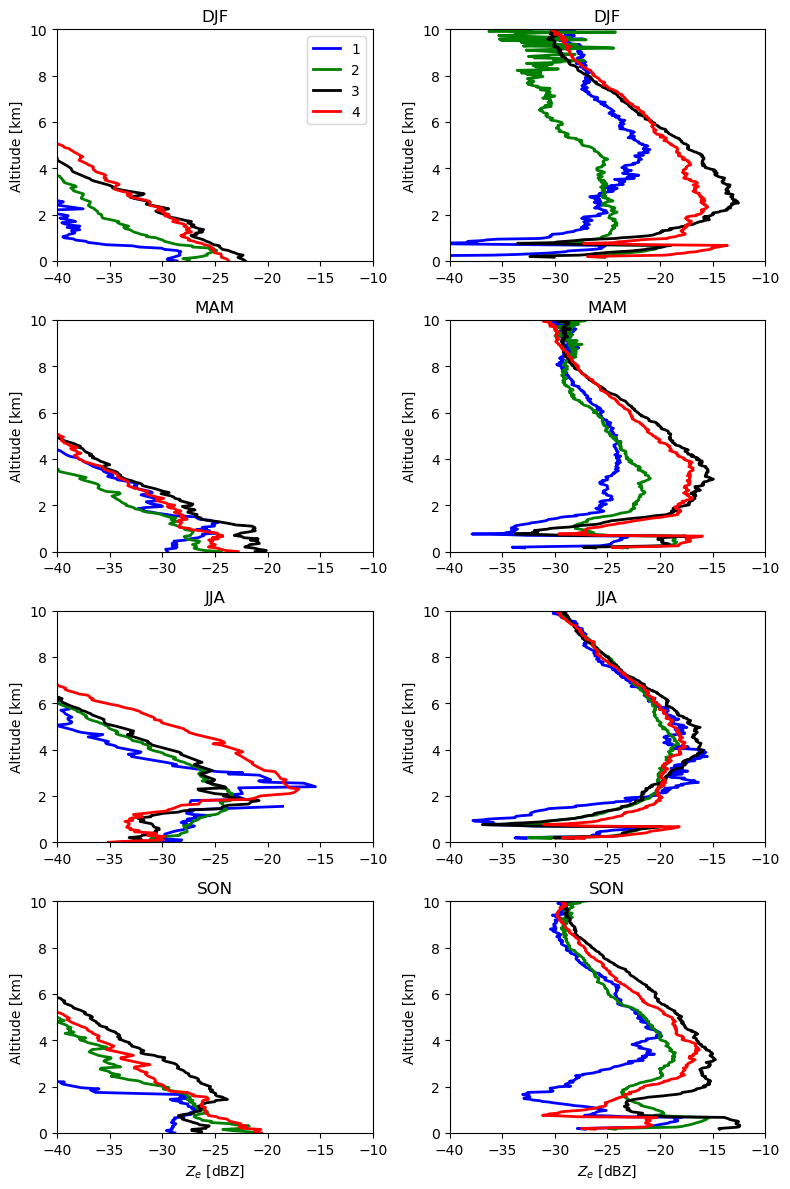

In [52]:
fig, ax = plt.subplots(4, 2, figsize=(8, 12))
colors = ['b', 'g', 'k', 'r']
i = 0
def cluster_mean(x, cluster_no):
    return x.where(x["cluster"] == cluster_no).mean("time", skipna=True)

for cluster in [1, 2, 3, 4]:
    cmean = lambda x: cluster_mean(x, cluster)
    e3sm_groupby = e3sm_avgs.groupby("season").apply(cmean)
    e3sm_groupby = e3sm_groupby.set_coords(["season", "lev"])
    
    for i, season in enumerate(["DJF", "MAM", "JJA", "SON"]):
        e3sm_groupby['Avg_Ze_height'].sel(season=season).T.plot(
            ax=ax[i, 0], y="height_prof", linewidth=2, label=str(cluster), color=colors[cluster - 1])

        ax[-1, 0].set_xlabel('$Z_{e}$ [dBZ]')   
        ax[i, 0].set_ylabel('Altitude [km]')
        ax[i, 0].set_title('')
        ax[i, 0].set_xlim([-40, -10])
        ax[i, 0].set_ylim([0, 10])
        #ax[i].invert_yaxis()
        ax[i, 0].set_title(season)
        ax[0, 0].legend()

        inds = np.logical_and(seasons == season, clusters == cluster)
        Ze_mean = np.nanmean(refls[inds, :], axis=0)
        ax[i, 1].plot(Ze_mean, heights / 1e3, color=colors[cluster - 1], linewidth=2)
        ax[i, 1].set_ylabel('Altitude [km]')
        ax[-1, 1].set_xlabel('$Z_{e}$ [dBZ]') 
        ax[i, 1].set_title('')
        ax[i, 1].set_xlim([-40, -10])
        ax[i, 1].set_ylim([0, 10])
        #ax[i].invert_yaxis()
        ax[i, 1].set_title(season)
        #ax[0, 1].legend()

for i in range(3):
    ax[i, 0].set_xlabel('')
    ax[i, 1].set_xlabel('')
fig.tight_layout()
fig.savefig('Ze_profiles.png')

In [60]:
height = e3sm_avgs["heights"].values
ARRAIN_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
ARSNOW_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
AREI_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
AREL_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
ARRAIN_array = e3sm_avgs["ADRAIN"] / 2. * 1e6
ARSNOW_array = e3sm_avgs["ADSNOW"] / 2. * 1e6
AREI_array = e3sm_avgs["AREI"] 
AREL_array = e3sm_avgs["AREL"]
rho = e3sm_avgs["P"] / (Rd * e3sm_avgs["T"])
NUMICE_array_interp = np.zeros((LWC_array.shape[0], len(heights))) 
NUMLIQ_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
NUMRAI_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
NUMSNO_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
NUMICE_array = e3sm_avgs["NUMICE"] * rho * 1e-3
NUMLIQ_array = e3sm_avgs["NUMLIQ"] * rho * 1e-3
NUMRAI_array = e3sm_avgs["NUMRAI"] * rho * 1e-6
NUMSNO_array = e3sm_avgs["NUMSNO"] * rho * 1e-6

for i in range(LWC_array.shape[0]):
    if i % 100 == 0:
        print('%d/%d' % (i, LWC_array.shape[0]))
    ARRAIN = interp1d(height[i, :], ARRAIN_array[i, :], fill_value="extrapolate")
    ARSNOW = interp1d(height[i, :], ARSNOW_array[i, :], fill_value="extrapolate")
    NUMRAI = interp1d(height[i, :], NUMRAI_array[i, :], fill_value="extrapolate")
    NUMSNO = interp1d(height[i, :], NUMSNO_array[i, :], fill_value="extrapolate")
    NUMICE = interp1d(height[i, :], NUMICE_array[i, :], fill_value="extrapolate")
    NUMLIQ = interp1d(height[i, :], NUMLIQ_array[i, :], fill_value="extrapolate")
    AREI = interp1d(height[i, :], AREI_array[i, :], fill_value="extrapolate")
    ARED = interp1d(height[i, :], AREL_array[i, :], fill_value="extrapolate")
    ARRAIN_array_interp[i, :] = ARRAIN(heights / 1e3)
    ARSNOW_array_interp[i, :] = ARSNOW(heights / 1e3)
    NUMICE_array_interp[i, :] = NUMICE(heights / 1e3)
    NUMLIQ_array_interp[i, :] = NUMLIQ(heights / 1e3)
    NUMRAI_array_interp[i, :] = NUMRAI(heights / 1e3)
    NUMSNO_array_interp[i, :] = NUMSNO(heights / 1e3)
    AREI_array_interp[i, :] = AREI(heights / 1e3)
    AREL_array_interp[i, :] = ARED(heights / 1e3)

0/18000
100/18000
200/18000
300/18000
400/18000
500/18000
600/18000
700/18000
800/18000
900/18000
1000/18000
1100/18000
1200/18000
1300/18000
1400/18000
1500/18000
1600/18000
1700/18000
1800/18000
1900/18000
2000/18000
2100/18000
2200/18000
2300/18000
2400/18000
2500/18000
2600/18000
2700/18000
2800/18000
2900/18000
3000/18000
3100/18000
3200/18000
3300/18000
3400/18000
3500/18000
3600/18000
3700/18000
3800/18000
3900/18000
4000/18000
4100/18000
4200/18000
4300/18000
4400/18000
4500/18000
4600/18000
4700/18000
4800/18000
4900/18000
5000/18000
5100/18000
5200/18000
5300/18000
5400/18000
5500/18000
5600/18000
5700/18000
5800/18000
5900/18000
6000/18000
6100/18000
6200/18000
6300/18000
6400/18000
6500/18000
6600/18000
6700/18000
6800/18000
6900/18000
7000/18000
7100/18000
7200/18000
7300/18000
7400/18000
7500/18000
7600/18000
7700/18000
7800/18000
7900/18000
8000/18000
8100/18000
8200/18000
8300/18000
8400/18000
8500/18000
8600/18000
8700/18000
8800/18000
8900/18000
9000/18000
9100/18000


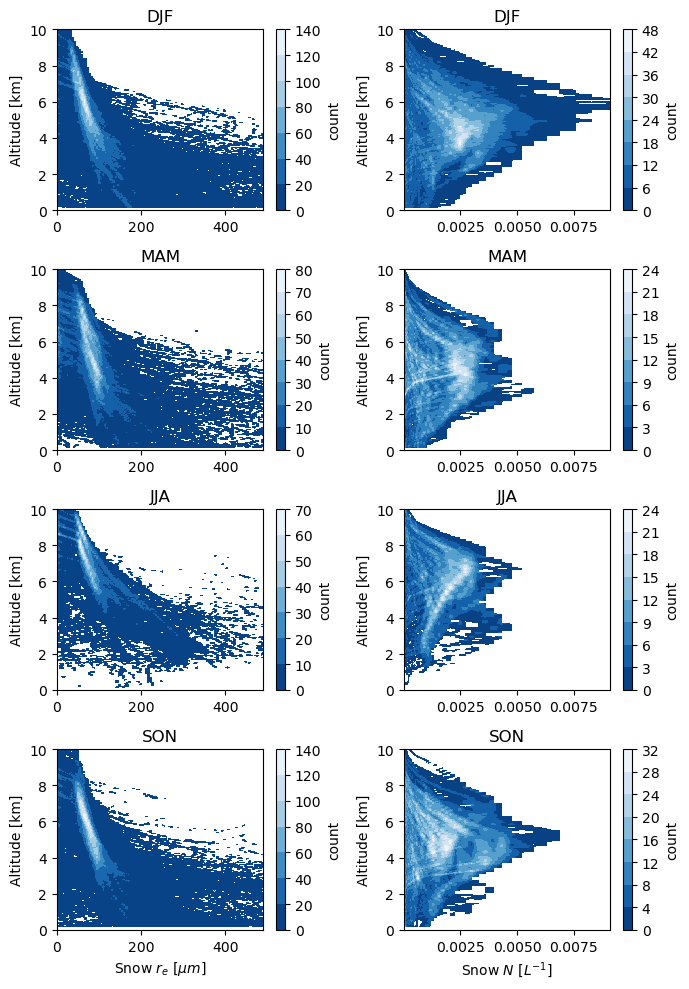

In [81]:
rei_bins = np.arange(0, 500, 5)
num_bins = np.logspace(-6, -2, 100)
fig, ax = plt.subplots(4, 2, figsize=(7, 10))
ARSNOW_array_interp = np.where(ARSNOW_array_interp > 0, ARSNOW_array_interp, np.nan)
NUMSNO_array_interp = np.where(NUMSNO_array_interp > 0, NUMSNO_array_interp, np.nan)
for k, seas in enumerate(["DJF", "MAM", "JJA", "SON"]):
    hist_rei = np.zeros((len(heights), len(rei_bins) - 1))
    hist_N = np.zeros((len(heights), len(num_bins) - 1))
    dom_label = 0
    cur_max = 0
    for i in range(4):
        num_in_label = np.sum(np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                              e3sm_avgs["class"].values == i + 1))
        if num_in_label > cur_max:
            dom_label = i + 1
    
    which_inds = np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                                e3sm_avgs["class"].values == dom_label)
        
    for i in range(len(heights)):
        hist, bins = np.histogram(ARSNOW_array_interp[which_inds, i], bins=rei_bins)
        hist_rei[i, :] = hist
        hist, bins = np.histogram(NUMSNO_array_interp[which_inds, i], bins=num_bins)
        hist_N[i, :] = hist
    hist_rei[hist_rei == 0] = np.nan
    hist_N[hist_N == 0] = np.nan
    x, y = np.meshgrid(rei_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 0].contourf(x, y, hist_rei.T, cmap='Blues_r')
    plt.colorbar(c, ax=ax[k, 0], label="count")
    ax[-1, 0].set_xlabel('Snow $r_{e}$ [$\mu m$]')
    ax[k, 0].set_ylabel('Altitude [km]')
    ax[k, 0].set_ylim([0, 10])
    ax[k, 0].set_title(seas)
    x, y = np.meshgrid(num_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 1].contourf(x, y, hist_N.T, cmap='Blues_r')
    plt.colorbar(c, ax=ax[k, 1], label="count")
    ax[-1, 1].set_xlabel('Snow $N$ [$L^{-1}$]')
    ax[k, 1].set_ylabel('Altitude [km]')
    ax[k, 1].set_ylim([0, 10])
    ax[k, 1].set_title(seas)
fig.tight_layout()
fig.savefig('Snow_microphysics.png', bbox_inches='tight')

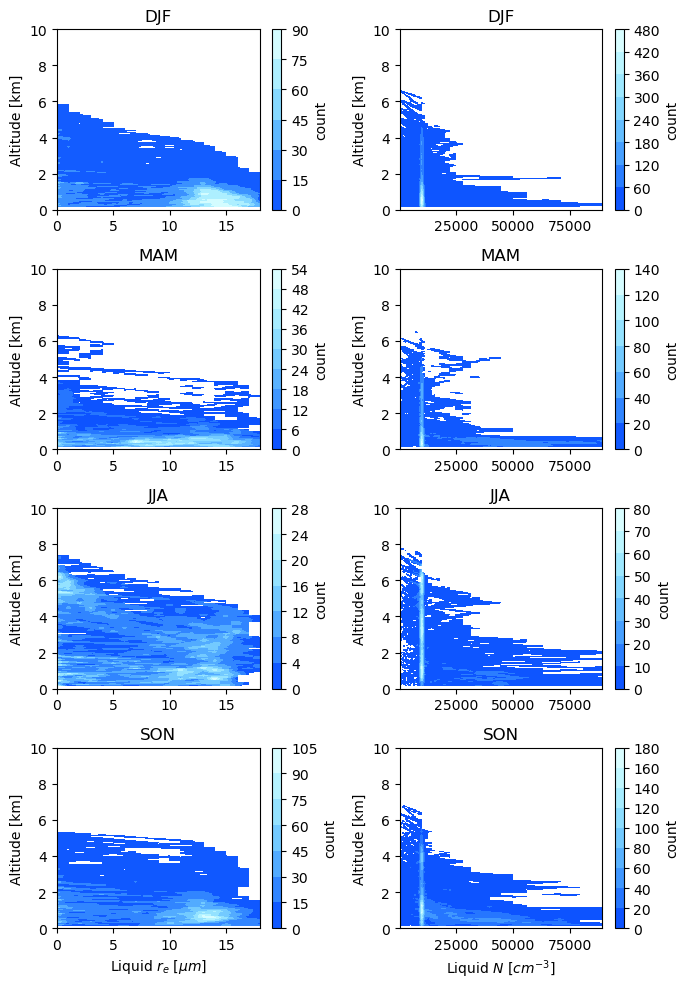

In [73]:
rei_bins = np.arange(0, 20, 1)
num_bins = np.logspace(0, 5, 100)
fig, ax = plt.subplots(4, 2, figsize=(7, 10))
AREL_array_interp = np.where(AREL_array_interp > 0, AREL_array_interp, np.nan)
NUMLIQ_array_interp = np.where(NUMLIQ_array_interp > 0, NUMLIQ_array_interp, np.nan)
for k, seas in enumerate(["DJF", "MAM", "JJA", "SON"]):
    hist_rei = np.zeros((len(heights), len(rei_bins) - 1))
    hist_N = np.zeros((len(heights), len(num_bins) - 1))
    dom_label = 0
    cur_max = 0
    for i in range(4):
        num_in_label = np.sum(np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                              e3sm_avgs["class"].values == i + 1))
        if num_in_label > cur_max:
            dom_label = i + 1
    
    which_inds = np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                                e3sm_avgs["class"].values == dom_label)
        
    for i in range(len(heights)):
        hist, bins = np.histogram(AREL_array_interp[which_inds, i], bins=rei_bins)
        hist_rei[i, :] = hist
        hist, bins = np.histogram(NUMLIQ_array_interp[which_inds, i], bins=num_bins)
        hist_N[i, :] = hist
    hist_rei[hist_rei == 0] = np.nan
    hist_N[hist_N == 0] = np.nan
    x, y = np.meshgrid(rei_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 0].contourf(x, y, hist_rei.T, cmap='Bu10_r')
    plt.colorbar(c, ax=ax[k, 0], label="count")
    ax[-1, 0].set_xlabel('Liquid $r_{e}$ [$\mu m$]')
    ax[k, 0].set_ylabel('Altitude [km]')
    ax[k, 0].set_ylim([0, 10])
    ax[k, 0].set_title(seas)
    x, y = np.meshgrid(num_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 1].contourf(x, y, hist_N.T, cmap='Bu10_r')
    plt.colorbar(c, ax=ax[k, 1], label="count")
    ax[-1, 1].set_xlabel('Liquid $N$ [$cm^{-3}$]')
    ax[k, 1].set_ylabel('Altitude [km]')
    ax[k, 1].set_ylim([0, 10])
    ax[k, 1].set_title(seas)
fig.tight_layout()
fig.savefig('Liquid_microphysics.png', bbox_inches='tight')

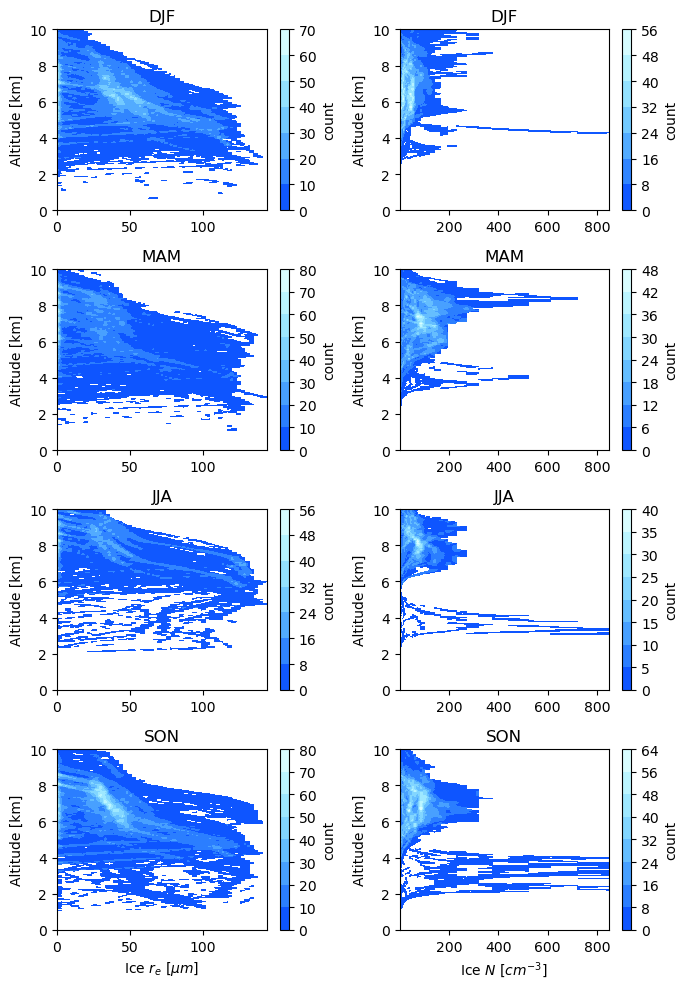

In [76]:
rei_bins = np.arange(0, 150, 3)
num_bins = np.logspace(-4, 3, 100)
fig, ax = plt.subplots(4, 2, figsize=(7, 10))
AREI_array_interp = np.where(AREI_array_interp > 0, AREI_array_interp, np.nan)
NUMICE_array_interp = np.where(NUMICE_array_interp > 0, NUMICE_array_interp, np.nan)
for k, seas in enumerate(["DJF", "MAM", "JJA", "SON"]):
    hist_rei = np.zeros((len(heights), len(rei_bins) - 1))
    hist_N = np.zeros((len(heights), len(num_bins) - 1))
    dom_label = 0
    cur_max = 0
    for i in range(4):
        num_in_label = np.sum(np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                              e3sm_avgs["class"].values == i + 1))
        if num_in_label > cur_max:
            dom_label = i + 1
    
    which_inds = np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                                e3sm_avgs["class"].values == dom_label)
        
    for i in range(len(heights)):
        hist, bins = np.histogram(AREI_array_interp[which_inds, i], bins=rei_bins)
        hist_rei[i, :] = hist
        hist, bins = np.histogram(NUMICE_array_interp[which_inds, i], bins=num_bins)
        hist_N[i, :] = hist
    hist_rei[hist_rei == 0] = np.nan
    hist_N[hist_N == 0] = np.nan
    x, y = np.meshgrid(rei_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 0].contourf(x, y, hist_rei.T, cmap='Bu10_r')
    plt.colorbar(c, ax=ax[k, 0], label="count")
    ax[-1, 0].set_xlabel('Ice $r_{e}$ [$\mu m$]')
    ax[k, 0].set_ylabel('Altitude [km]')
    ax[k, 0].set_ylim([0, 10])
    ax[k, 0].set_title(seas)
    x, y = np.meshgrid(num_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 1].contourf(x, y, hist_N.T, cmap='Bu10_r')
    plt.colorbar(c, ax=ax[k, 1], label="count")
    ax[-1, 1].set_xlabel('Ice $N$ [$cm^{-3}$]')
    ax[k, 1].set_ylabel('Altitude [km]')
    ax[k, 1].set_ylim([0, 10])
    ax[k, 1].set_title(seas)
fig.tight_layout()
fig.savefig('Ice_microphysics.png', bbox_inches='tight')

/gpfs/fs1/home/rjackson/mambaforge/envs/pyart_bebop/lib/python3.11/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/gpfs/fs1/home/rjackson/mambaforge/envs/pyart_bebop/lib/python3.11/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/gpfs/fs1/home/rjackson/mambaforge/envs/pyart_bebop/lib/python3.11/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/gpfs/fs1/home/rjackson/mambaforge/envs/pyart_bebop/lib/python3.11/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/gpfs/fs1/home/rjackson/mambaforge/envs/pyart_bebop/lib/python3.11/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/gpfs/fs1/home/rjack

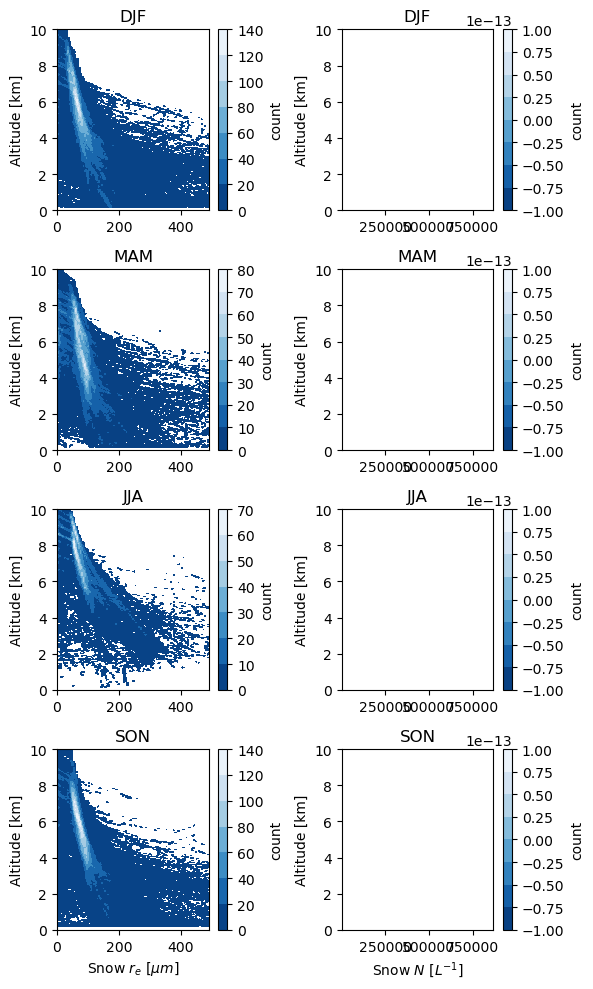

In [80]:
rei_bins = np.arange(0, 500, 5)
num_bins = np.logspace(0, 6, 100)
fig, ax = plt.subplots(4, 2, figsize=(6, 10))
ARRAIN_array_interp = np.where(ARSNOW_array_interp > 0, ARSNOW_array_interp, np.nan)
NUMRAI_array_interp = np.where(NUMRAI_array_interp > 0, NUMRAI_array_interp, np.nan)
for k, seas in enumerate(["DJF", "MAM", "JJA", "SON"]):
    hist_rei = np.zeros((len(heights), len(rei_bins) - 1))
    hist_N = np.zeros((len(heights), len(num_bins) - 1))
    dom_label = 0
    cur_max = 0
    for i in range(4):
        num_in_label = np.sum(np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                              e3sm_avgs["class"].values == i + 1))
        if num_in_label > cur_max:
            dom_label = i + 1
    
    which_inds = np.logical_and(e3sm_avgs.time.dt.season.values == seas,
                                e3sm_avgs["class"].values == dom_label)
        
    for i in range(len(heights)):
        hist, bins = np.histogram(ARSNOW_array_interp[which_inds, i], bins=rei_bins)
        hist_rei[i, :] = hist
        hist, bins = np.histogram(NUMSNO_array_interp[which_inds, i], bins=num_bins)
        hist_N[i, :] = hist
    hist_rei[hist_rei == 0] = np.nan
    hist_N[hist_N == 0] = np.nan
    x, y = np.meshgrid(rei_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 0].contourf(x, y, hist_rei.T, cmap='Blues_r')
    plt.colorbar(c, ax=ax[k, 0], label="count")
    ax[-1, 0].set_xlabel('Snow $r_{e}$ [$\mu m$]')
    ax[k, 0].set_ylabel('Altitude [km]')
    ax[k, 0].set_ylim([0, 10])
    ax[k, 0].set_title(seas)
    x, y = np.meshgrid(num_bins[:-1], heights / 1e3, indexing='ij')
    c = ax[k, 1].contourf(x, y, hist_N.T, cmap='Blues_r')
    plt.colorbar(c, ax=ax[k, 1], label="count")
    ax[-1, 1].set_xlabel('Snow $N$ [$L^{-1}$]')
    ax[k, 1].set_ylabel('Altitude [km]')
    ax[k, 1].set_ylim([0, 10])
    ax[k, 1].set_title(seas)
fig.tight_layout()
fig.savefig('Rain_microphysics.png', bbox_inches='tight')

In [72]:
NUMSNO_array

<xarray.DataArray 'NUMSNO' (time: 18000, lev: 72)>
array([[1.000000e-12, 1.000000e-12, 1.000000e-12, ..., 9.961126e-01,
        1.027731e+00, 1.042116e+00],
       [1.000000e-12, 1.000000e-12, 1.000000e-12, ..., 9.931056e-01,
        9.354649e-01, 9.086934e-01],
       [1.000000e-12, 1.000000e-12, 1.000000e-12, ..., 1.405397e+00,
        1.349213e+00, 1.323021e+00],
       ...,
       [1.000000e-12, 1.000000e-12, 1.000000e-12, ..., 4.989690e+01,
        5.052849e+01, 5.078683e+01],
       [1.000000e-12, 1.000000e-12, 1.000000e-12, ..., 4.687043e+01,
        4.753429e+01, 4.781018e+01],
       [1.000000e-12, 1.000000e-12, 1.000000e-12, ..., 4.448421e+01,
        4.502760e+01, 4.524813e+01]], dtype=float32)
Coordinates:
  * lev      (lev) float64 0.1238 0.1828 0.2699 0.3986 ... 986.2 993.8 998.5
  * time     (time) object 2004-12-27 00:00:00 ... 2007-01-15 23:00:00
Attributes:
    mdims:         1
    units:         1/kg
    mixing_ratio:  wet
    long_name:     Grid box averaged snow number
    cell_methods:  time: mean
    basename:      NUMSNO